# Завантажуємо модель

Кількість вагів та розміри тензорів були вирахувані протягом заняття

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     # <- (3*3 + 1)*32 = 320
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    # <- (3*3)*32*64 + 64 = 18496
        self.dropout1 = nn.Dropout(0.25)        # <- 0
        self.dropout2 = nn.Dropout(0.5)         # <- 0
        self.fc1 = nn.Linear(9216, 128)         # <- 9216*128 + 128 = 1179776
        self.fc2 = nn.Linear(128, 10)           # <- 128*10 + 10 = 1290

    def forward(self, x):           # [128,  1, 28, 28]
        x = self.conv1(x)           # [128, 32, 26, 26]
        x = F.relu(x)               # [128, 32, 26, 26]
        x = self.conv2(x)           # [128, 64, 24, 24]
        x = F.relu(x)               # [128, 64, 24, 24]
        x = F.max_pool2d(x, 2)      # [128, 64, 12, 12]
        x = self.dropout1(x)        # [128, 64, 12, 12]
        x = torch.flatten(x, 1)     # [128, 64x12x12 = 9216]
        x = self.fc1(x)             # [128, 128]
        x = F.relu(x)               # [128, 128]
        x = self.dropout2(x)        # [128, 128]
        output = self.fc2(x)        # [128, 10]
        return output


def train(model, device, train_loader, optimizer, epoch, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():

    torch.manual_seed(1337)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_kwargs = {'batch_size': 128}
    test_kwargs = {'batch_size': 128}

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.MNIST('./mnsit-dataset', train=True, download=True,
                              transform=transform)
    test_dataset = datasets.MNIST('./mnsit-dataset', train=False,
                              transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    epochs = 5

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=0.1)
    loss_fn = torch.nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, loss_fn)
        test(model, device, test_loader, loss_fn)
        scheduler.step()

    torch.save(model.state_dict(), "mnist_cnn.pt")
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(1, 28, 28)))


if __name__ == '__main__':
    main()

100%|█| 9912422/9912422 [00:00<00:00, 6


Extracting ./mnsit-dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./mnsit-dataset/MNIST/raw



100%|█| 28881/28881 [00:00<00:00, 63621

Extracting ./mnsit-dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnsit-dataset/MNIST/raw



100%|█| 1648877/1648877 [00:00<00:00, 2

Extracting ./mnsit-dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnsit-dataset/MNIST/raw



100%|█| 4542/4542 [00:00<00:00, 9937678

Extracting ./mnsit-dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnsit-dataset/MNIST/raw



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300337
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.435686
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.312622
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.382169
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.461395

Test set: Average loss: 0.0017, Accuracy: 9320/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.242895
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.194571
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.273831
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.254619
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.291336

Test set: Average loss: 0.0012, Accuracy: 9520/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.139687
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.204698
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.170477
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.155989
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.313100

Test set: Average loss: 0.0011, Accuracy: 9577/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.159638
Train Epoch: 4 [12800/60000 (21%)]	Lo

# Змінюємо код

Робимо так, щоб модель зробила overfit

Будуємо графік лосу

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     # <- (3*3 + 1)*32 = 320
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    # <- (3*3)*32*64 + 64 = 18496
        self.conv3 = nn.Conv2d(64, 128, 3, 1)   # <- (3*3)*64*128 + 128 = 73856
        self.conv4 = nn.Conv2d(128, 256, 3, 1)  # <- (3*3)*128*256 + 256 = 295168
        self.fc1 = nn.Linear(102400, 128)       # <- 128*102400 + 102400 = 13209600
        self.fc2 = nn.Linear(128, 128)          # <- 128*128 + 128 = 16512
        self.fc3 = nn.Linear(128, 10)           # <- 128*10 + 128 = 1408

    def forward(self, x):           # [128,  1, 28, 28]
        x = self.conv1(x)           # [128, 32, 26, 26]
        x = F.relu(x)               # [128, 32, 26, 26]
        x = self.conv2(x)           # [128, 64, 24, 24]
        x = F.relu(x)               # [128, 64, 24, 24]
        x = self.conv3(x)           # [128, 128, 22, 22]
        x = F.relu(x)               # [128, 128, 22, 22]
        x = self.conv4(x)           # [128, 256, 20, 20]
        x = torch.flatten(x, 1)     # [128, 256x20x20 = 102400]
        x = self.fc1(x)             # [128, 128]
        x = self.fc2(x)             # [128, 128]
        x = self.fc3(x)             # [128, 10]
        output = F.relu(x)          # [128, 10]
       
        return output


def train(model, device, train_loader, optimizer, epoch, loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        train_acc = accuracy_score(target, pred) * 100
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                 train_acc))


def test(model, device, test_loader, loss_fn):
    test_loss = 0
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



def main():
    torch.manual_seed(1337)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_kwargs = {'batch_size': 100}
    test_kwargs = {'batch_size': 100}

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.MNIST('./mnsit-dataset', train=True, download=False,
                              transform=transform)
    test_dataset = datasets.MNIST('./mnsit-dataset', train=False,
                              transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    epochs = 20

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    loss_fn = torch.nn.CrossEntropyLoss()

    # scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, loss_fn)
        test(model, device, test_loader, loss_fn)
        # scheduler.step()

    # torch.save(model.state_dict(), "mnist_cnn_overfited.pt")
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(1, 28, 28)))
    plt.plot(test_loss)

if __name__ == '__main__':
    main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303988	Acc: 8.00%
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.461328	Acc: 87.00%
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.301088	Acc: 93.00%
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.183129	Acc: 94.00%
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.089158	Acc: 97.00%
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.064315	Acc: 97.00%

Test set: Average loss: 0.0009, Accuracy: 9720/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.121380	Acc: 98.00%
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.082799	Acc: 97.00%
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.098034	Acc: 98.00%
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.064790	Acc: 99.00%
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.051988	Acc: 98.00%
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.020297	Acc: 100.00%

Test set: Average loss: 0.0006, Accuracy: 9794/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.111041	Acc: 98.00%
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.060561	Acc: 97.00%
Train Epoch: 3 [20000/600

KeyboardInterrupt: 

# Результат overfit

Зробити overfit моделі не вдалось.

Були використанні наступні дії:

- Обирався великий convolution layer
- Обирався малий convolution layer
- Використовувались різні кількості convolution layer
- Обирався великий класифікатор
- Обирався малий класифікатор
- Використовувались різні кількості функцій активації
- Обирались різні оптимізатори
- Обирались різні кількості епох
- Обирались різні розміри batch
- Проводилось тренування на меншій кількості данних (5000, 10000)

Вдавалось лише досягти underfit

# Будуємо зменшену модель та метрики результатів

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.384709	Acc: 9.00%
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.187368	Acc: 94.00%
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.241885	Acc: 93.00%
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.126167	Acc: 96.00%
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.064353	Acc: 98.00%
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.064631	Acc: 98.00%

Test set: Average loss: 0.0008, Accuracy: 9738/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.116834	Acc: 99.00%
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.076282	Acc: 96.00%
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.066652	Acc: 97.00%
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.084309	Acc: 97.00%
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.035350	Acc: 98.00%
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.028685	Acc: 99.00%

Test set: Average loss: 0.0004, Accuracy: 9861/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.086654	Acc: 99.00%
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.036294	Acc: 98.00%
Train Epoch: 3 [20000/6000

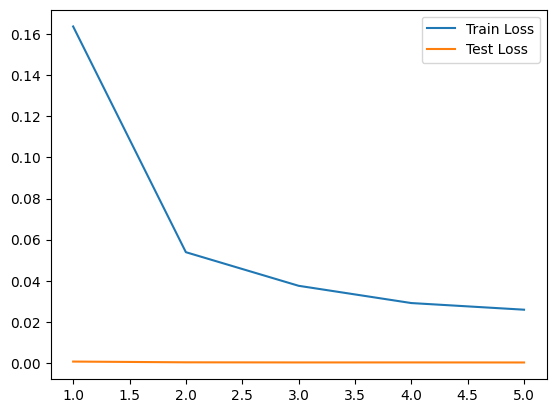

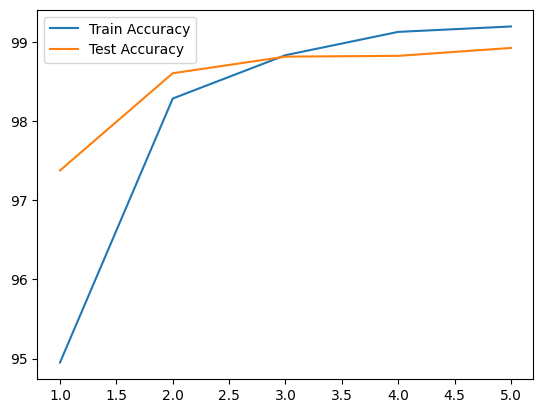

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      1.00      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



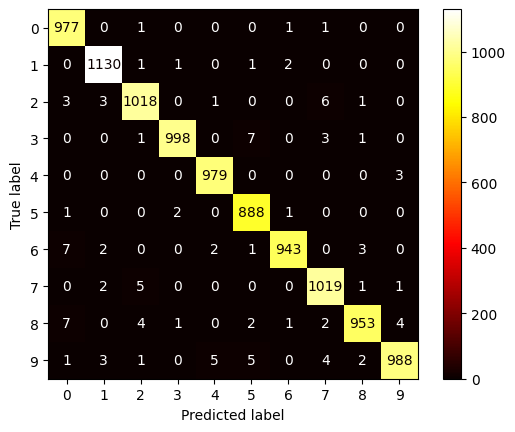

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2304, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)

        return output


def train(model, device, train_loader, optimizer, epoch, loss_fn):
    train_losses = []
    train_accs = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_losses.append(loss.item())
        pred = output.argmax(dim=1, keepdim=True)
        train_accs.append(accuracy_score(target, pred) * 100)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                 accuracy_score(target, pred) * 100))
    return train_losses, train_accs

def test(model, device, test_loader, loss_fn):
    test_accs = []
    test_loss = 0
    tr_labels = []
    pr_labels = []
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += loss_fn(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        pr = outputs.argmax(1)
        tr_labels.append(labels.numpy())
        pr_labels.append(pr.numpy())

    tr_labels = np.concatenate(tr_labels)
    pr_labels = np.concatenate(pr_labels)
    test_accs.append(accuracy_score(tr_labels, pr_labels) * 100)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_accs, test_loss


def main():
    avg_test_acc = []
    avg_test_loss = []
    avg_train_acc = []
    avg_train_loss = []
    torch.manual_seed(1337)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_kwargs = {'batch_size': 100}
    test_kwargs = {'batch_size': 100}

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.MNIST('./mnsit-dataset', train=True, download=False,
                              transform=transform)
    test_dataset = datasets.MNIST('./mnsit-dataset', train=False,
                              transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

    epochs = 5

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
    for epoch in range(1, epochs + 1):

        train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, loss_fn)
        test_acc, test_loss = test(model, device, test_loader, loss_fn) 
        avg_train_loss.append(sum(train_loss) / len(train_loss))
        avg_test_loss.append(test_loss)
        avg_train_acc.append(sum(train_acc) / len(train_acc))
        avg_test_acc.append(sum(test_acc) / len(test_acc))
        scheduler.step()

    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(model)
    print(summary(model, input_size=(1, 28, 28)))

    plt.plot(range(1, epochs+1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, epochs+1), avg_test_loss, label='Test Loss')
    plt.legend()
    plt.show()

    plt.plot(range(1, epochs+1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, epochs+1), avg_test_acc, label='Test Accuracy') 
    plt.legend()
    plt.show()

    true_labels = []
    predicted_labels = []
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        predicted = outputs.argmax(1)
        true_labels.append(labels.numpy())
        predicted_labels.append(predicted.numpy())

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    matrix = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

    disp.plot(cmap=plt.colormaps["hot"])
    plt.savefig("confusion_matrix.png")
    print(classification_report(true_labels, predicted_labels))

if __name__ == '__main__':
    main()


# Висновки

На данній моделі найкраще класифікується одиниця, двійка та сімка

Загальна точність моделі 99%